# Трекинг игроков на волейбольной площадке

## Постановка задачи

Профессиональный спорт в последние годы выходит на все более высокий уровень, одного лишь качества собственной игры и предварительного анализа игровых действий соперника становится недостаточно. В связи с этим требуется более технологичный подход к данной задаче, позволяющий своевременно измененять и корректировать игровые стратегии, выявляя слабые и сильные места команд. Однако проводить этот анализ вручную – задача объемная, в связи с чем нередко могут возникать ошибки на основе человеческого фактора, а найм профессионала не всегда является возможным. Между тем, подобная статистика имеет основной смысл во время матча, а не после него, и здесь уже точно не удастся обойтись без помощи технологий.

В рамках данной работы будет рассмотрена задача определения и отслеживания игроков на волейбольной площадке, а также их номеров и расположения относительно поля, на основе чего можно построить тепловую карту игроков на площадке и проанализировать, какие корректировки в своих перемещениях могут сделать игроки.

## Этапы решения задачи

1. [Работа с исходными данными](#dataset)

2. [Определение игроков на площадке](#recognition)

3. [Отрисовка игровой площадки](#field)

4. [Трекинг игроков](#tracking)

5. [Отладка](#debugging)


### Импорт необходимых библиотек

In [523]:
import cv2
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
from IPython.display import YouTubeVideo
from scipy.spatial import distance
import random
import os

## 1. Работа с исходными данными <a id="dataset"></a>

За основу взяты данные из открытого источника – [записи игр австрийской лиги по волейболу](https://www.tugraz.at/institute/icg/research/team-bischof/lrs/downloads/vb14/).

 Данные содержат:
 * видеозаписи
 * файл activities.txt – набор действий, использованных в наборе данных.
 * файл annotations.txt – таблица данных.

### Описание таблицы

Общий вид: [video_nr | frame | activity_nr | bx1 | by1 | bx2 | by2 | w | h | pnum | is_opponent | offset]

**video_nr** - number of video (according to the order in 'videos.txt')

**frame** - frame of video with number video_nr

**activity_nr** - number of activity (according to the order in 'activities.txt')

**b*** - points marking the annotated bounding box (b*1: upper left corner, b*2: lower right corner, w: width, h:height)

**pnum** - number of the player

**is_opponent** - flag if annotated player is opponent (used for selecting the correct GMM)

**offset** - 4 values containing the bounding box for cropped videos (results of cutTrackletsFromVideo.m)


In [2]:
# Read df
names = ['video_nr', 'frame', 'activity_nr', 'bx1', 'by1', 'bx2', 'by2', 'w', 'h', 
         'pnum', 'is_opponent', 'offset1', 'offset2', 'offset3', 'offset4']
coord_names = ['bx1', 'by1', 'bx2', 'by2']
df = pd.read_csv("annotations.txt", delim_whitespace=True, names=names)

# Convert columns to correct dtypes
df.video_nr = df.video_nr.astype(int)
df.frame = df.frame.astype(int)
df.activity_nr = df.activity_nr.astype(int)
df.bx1 = df.bx1.astype(int)
df.bx2 = df.bx2.astype(int)
df.by1 = df.by1.astype(int)
df.by2 = df.by2.astype(int)
df.pnum = df.pnum.astype(int)
df.is_opponent = df.is_opponent.astype(bool)

df.head()

video_nr  frame  activity_nr  bx1  by1  bx2  by2      w      h  pnum  \
0         1   7240            1  375  394  620  839  245.0  445.0     2   
1         1   7241            1  376  394  621  839  245.0  445.0     2   
2         1   7242            1  377  394  622  839  245.0  445.0     2   
3         1   7243            1  377  394  622  839  245.0  445.0     2   
4         1   7244            1  378  394  623  839  245.0  445.0     2   

   is_opponent  offset1  offset2  offset3  offset4  
0        False     34.0      1.0    279.0    446.0  
1        False     35.0      1.0    280.0    446.0  
2        False     36.0      1.0    281.0    446.0  
3        False     36.0      1.0    281.0    446.0  
4        False     37.0      1.0    282.0    446.0

#### Вспомогательные функции

Реализуем функции для получения и отрисовки данных из набора.

<a id='aaaaa'></a>

In [3]:
with open("videos.txt") as file:
    videos = [line.rstrip() for line in file]
    
with open("activities.txt") as file:
    activities = [line.rstrip() for line in file]
    
    
def get_video_name_by_number(video_id):
    return videos[video_id - 1]


def get_activity_by_number(act_id):
    return activities[act_id - 1]


def get_frame_number(df, frame_row):
    return df[df.frame == frame_row.frame].frame


def get_frame_info(df, frame_number):
    return df[df.frame == frame_number]


def get_frame(video_cap, frame_num):
    video_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num-1)
    return video_cap.read()


def draw_frame(frame, patch=None, color='g'):
    _, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if patch is not None:
        rect = patches.Rectangle((patch[0], patch[1]), patch[2] - patch[0], patch[3] - patch[1], 
                                 linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Draw frame from video by its number
def draw_video_frame(video, frame_num, box=None):
    _, frame = get_frame(video, frame_num)
    draw_frame(frame, patch=box)
    
# Function for placing patch on frame
def patch_frame(frame, info, color=(0, 255, 0)):
    patch = info[coord_names]
    cv2.rectangle(frame, [patch[0], patch[1]], [patch[2], patch[3]], color, 1)
    label = f"Player {info.pnum}: {get_activity_by_number(info.activity_nr)}"
    cv2.putText(frame, label, (patch[0], patch[1]-10), cv2.FONT_HERSHEY_COMPLEX, 1, color, 2)

# add all patch data for frame by its number
def full_patch(df, frame, frame_num, color=(0, 255, 0)):
    for _, info in df[df.frame == frame_num].iterrows():
        patch = info[coord_names]
        cv2.rectangle(frame, [patch[0], patch[1]], [patch[2], patch[3]], color, 1)
        label = f"Player {info.pnum}: {get_activity_by_number(info.activity_nr)}"
        cv2.putText(frame, label, (patch[0], patch[1]-10), cv2.FONT_HERSHEY_COMPLEX, 1, color, 2)

Считаем первое видео

In [4]:
vid_num = 1
vid_name = get_video_name_by_number(vid_num)
video = cv2.VideoCapture(vid_name)

df_cut = df[df.video_nr == vid_num]
df_cut

video_nr  frame  activity_nr  bx1  by1  bx2  by2      w      h  pnum  \
0            1   7240            1  375  394  620  839  245.0  445.0     2   
1            1   7241            1  376  394  621  839  245.0  445.0     2   
2            1   7242            1  377  394  622  839  245.0  445.0     2   
3            1   7243            1  377  394  622  839  245.0  445.0     2   
4            1   7244            1  378  394  623  839  245.0  445.0     2   
...        ...    ...          ...  ...  ...  ...  ...    ...    ...   ...   
7074         1  19285            5  129  406  314  742  185.0  337.0    18   
7075         1  19286            5  128  405  314  743  186.0  338.0    18   
7076         1  19287            5  128  405  315  745  187.0  340.0    18   
7077         1  19288            5  127  404  315  746  188.0  341.0    18   
7078         1  19289            5  126  404  315  747  189.0  343.0    18   

      is_opponent  offset1  offset2  offset3  offset4  
0           False     34.0      1.0    279.0    446.0  
1           False     35.0      1.0    280.0    446.0  
2           False     36.0      1.0    281.0    446.0  
3           False     36.0      1.0    281.0    446.0  
4           False     37.0      1.0    282.0    446.0  
...           ...      ...      ...      ...      ...  
7074        False    129.0     60.0    314.0    396.0  
7075        False    128.0     59.0    314.0    397.0  
7076        False    128.0     59.0    315.0    399.0  
7077        False    127.0     58.0    315.0    400.0  
7078        False    126.0     58.0    315.0    401.0  

[7079 rows x 15 columns]

Отрисуем первый кадр, на котором определен игрок

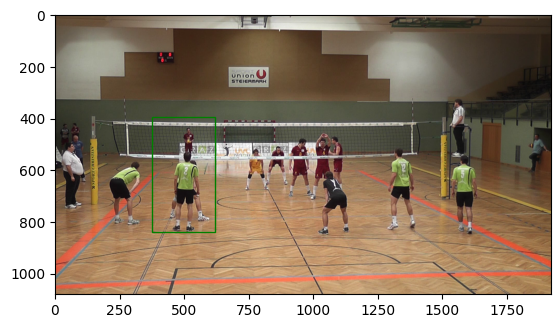

video_nr           1
frame           7240
activity_nr        1
bx1              375
by1              394
bx2              620
by2              839
w              245.0
h              445.0
pnum               2
is_opponent    False
offset1         34.0
offset2          1.0
offset3        279.0
offset4        446.0
Name: 0, dtype: object

In [5]:
df_first = df.iloc[0]
res, frame = get_frame(video, df_first.frame)
draw_frame(frame, df_first[coord_names])
df_first

Отрисуем 5 кадров из набора данных, чтобы понять, как были размечены данные.

  0%|          | 0/5 [00:00<?, ?it/s]

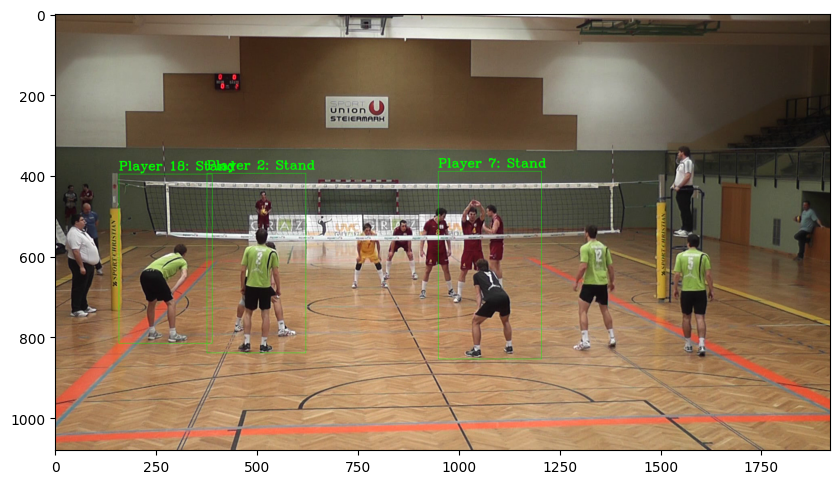

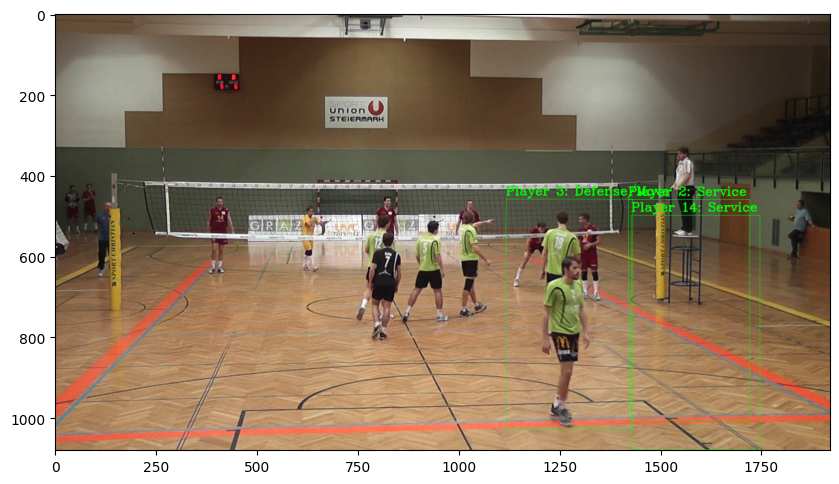

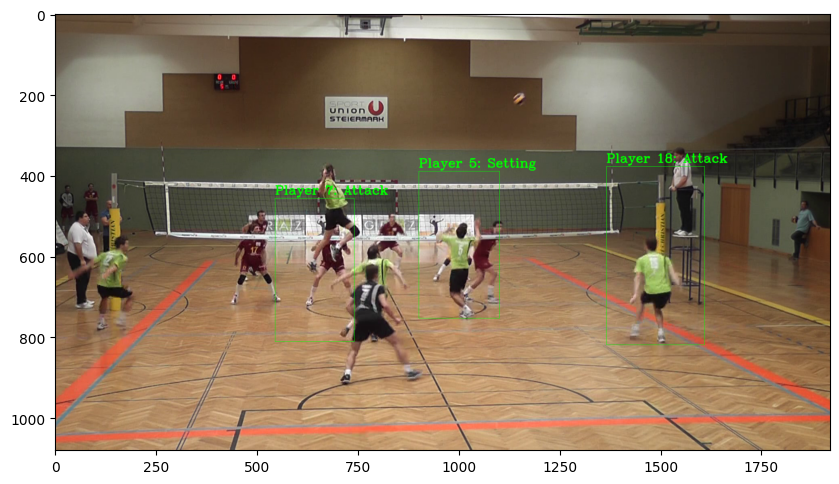

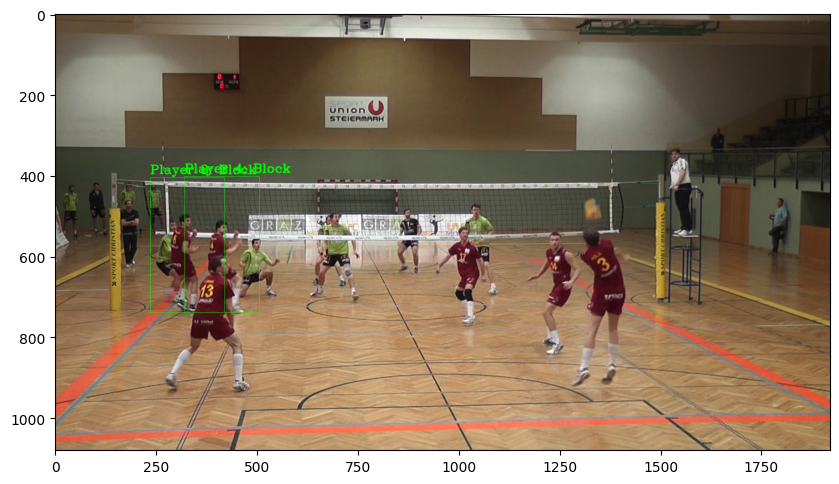

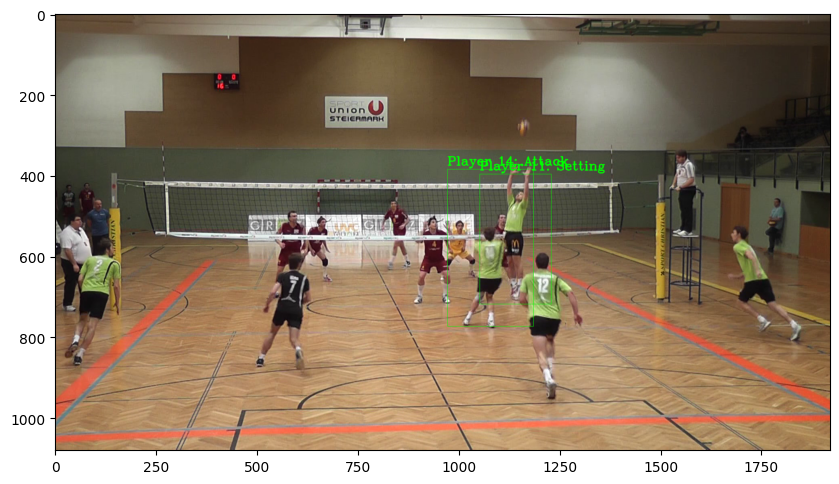

In [6]:
# Plot frames by its number in dataframe
def plot_frames(df, video_nr, frames, make_patch=True):
    video = cv2.VideoCapture(get_video_name_by_number(video_nr))
    for i in tqdm(range(len(frames))):
        frame_number = df[(df.frame == frames[i].frame) & (df.video_nr == video_nr)].iloc[0].frame
        ret, frame = get_frame(video, frame_number)
        if not ret:
            break
        
        if make_patch:
            full_patch(df, frame, frame_number)
        
        plt.figure(figsize = (10, 8))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plot_frames(df, 1, [df.iloc[i] for i in range(1, 5000, 1000)])

#### Качество разметки

По кадрам видно, что качество разметки очень слабое:
* Размечены то 1-2 игрока, то 3 или 4, хотя в совокупности на площадке их 12.
* Либо рамки слишком большие, либо игрок вообще оказывается за их пределами
* Действия игроков также размечены неудачно

В связи с этим в дальнейшем мы не будем использовать файл annotations.txt, опираться будем лишь на видеозаписи.

## 2. Определение игроков на площадке <a id="recognition"></a>

Для задачи определения игроков на площадке выбрана модель [YOLOv8](https://docs.ultralytics.com/) от Ultralytics в связи с тем, что YOLO по сравнению со многими другими архитектурами обладает достаточно большой скоростью, которая в рамках данной задачи играет важную роль, и на момент написания написания проекта 8-я версия – новейшая.

Для её использвания достаточно импортировать модель, а затем загрузить набор весов, который был получен в результате обучения на наборе данных [ImageNet](https://www.image-net.org/download.php).

Реализуем функцию, которая для заданного набора кадров будет определять на каждом из них игроков, а также выводить информацию и уверенность в том, что игрок определен верно.

In [7]:
from ultralytics import YOLO

# Filter for detecting players only
labels = {0: "people"}

def cxcywh_to_tlwh(box):
    return [box[0] + box[2] / 2, box[1] + box[3] / 2, box[2], box[3]]


def make_video_detections(video_name, frames, 
                          min_detect_conf=0.5, 
                          bbox_color=(0, 255, 0),
                          show_conf=True, out_name='out'):
    
    yolo_model = YOLO("yolov8n.pt")
    yolo_model.to("cuda")

    # Open video and set frame to first from given range
    video_cap = cv2.VideoCapture(video_name)
    video_cap.set(cv2.CAP_PROP_POS_FRAMES, frames[0] - 1)
    ret, frame = video_cap.read()
    
    # Get information about FPS, width and heigth of the video and create new video with same parameters.
    fps = video_cap.get(cv2.CAP_PROP_FPS)
    w = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(f"{out_name}.mp4", fourcc, fps, (w, h))
    
    # For every frame in given range get detected boxes and for every bounding box make rectangle with label
    for frame_num in tqdm(range(frames[0], frames[-1] + 1)):

        for res in yolo_model(frame, conf=min_detect_conf, verbose=False):
            for idx, (name, confidence, box) in enumerate(zip(res.boxes.cls.int().tolist(), 
                                                              res.boxes.conf.tolist(), 
                                                              res.boxes.data.int().tolist())):
                if labels.get(name):
                    label = f"Player {idx}"
                    if show_conf:
                        label += f" ({confidence:.3})"
                    cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), bbox_color, 1)
                    cv2.putText(frame, label, (box[0], box[1]-10), cv2.FONT_HERSHEY_COMPLEX, 0.6, bbox_color, 2)
        out.write(frame)
        ret, frame = video_cap.read()
        if not ret:
            break

    video_cap.release()
    out.release()


In [518]:
make_video_detections(vid_name, range(5625, 7625), out_name="yolo_detect")

  0%|          | 0/2000 [00:00<?, ?it/s]

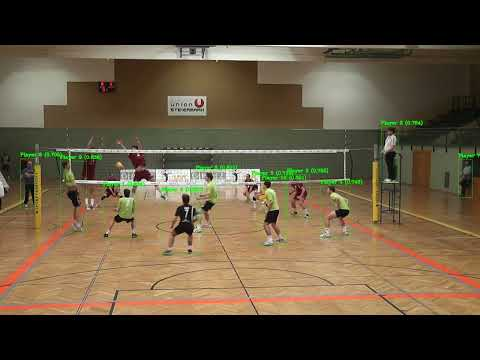

In [525]:
YouTubeVideo('JKqm4aesi2Y', width=640, height=360)

Основные выявленные проблемы и узкие места:

1. Среди игроков появляются судьи и зрители
2. Игроки на другой половине площадки определяются плохо в связи с тем, что их видно хуже
3. Игроки зачастую перекрывают друг друга – в особенности в моменты, когда собираются в центре поля после забитого мяча

## 3. Отрисовка игровой площадки <a id="field"></a>

Для того, чтобы решить проблемы 1 и 2, указанные выше, уберем из рассмотрения противоположную половину площадки, а также то, что находится далеко за её пределами. 

Таким образом, чтобы отфильтровать интересующих нас игроков, будем смотреть на происходящее относительно игрового поля. Чтобы определять, находится игрок на площадке или за её пределами, прибегнем к проекции на плоскость площадки.

Построим проекцию по четырем точкам, а с помощью пятой проверим, насколько успешно это удалось.

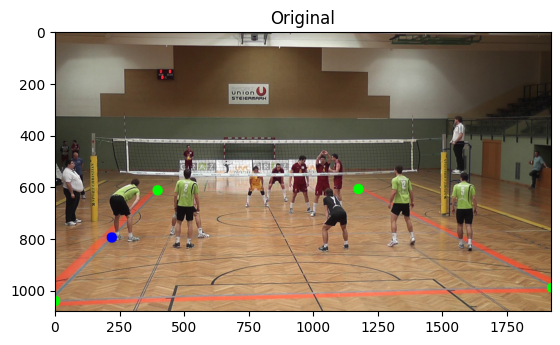

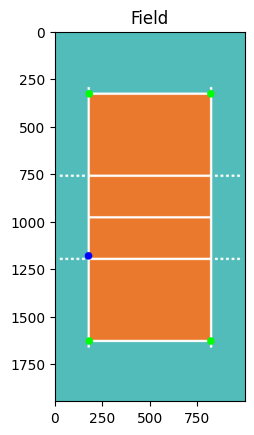

In [8]:
ret, frame = get_frame(video, df_first.frame)
base_image = frame.copy()
field_image = cv2.imread('field.png')
small_field = cv2.imread('field_small.png')

color = (0, 255, 0)

# Video points of field
p11, p12, p13, p14 = [0, 1041],[1920, 990],[1172, 609],[396,614]
# Image points of field
p21, p22, p23, p24 = [180, 1630],[820, 1630],[820, 330],[180, 330]

pts1=np.float32([p11, p12, p13, p14]) 
pts2=np.float32([p21, p22, p23, p24])

# Create transformation matrix
matrix = cv2.getPerspectiveTransform(pts1, pts2)

# Draw points on images
for p in pts1:
    cv2.circle(base_image, p.astype(int), 20, color, -1)
    
for p in pts2:
    cv2.circle(field_image, p.astype(int), 20, color, -1)



# Check results for point from video
p = (219, 796)
px = (matrix[0][0]*p[0] + matrix[0][1]*p[1] + matrix[0][2]) / ((matrix[2][0]*p[0] + matrix[2][1]*p[1] + matrix[2][2]))
py = (matrix[1][0]*p[0] + matrix[1][1]*p[1] + matrix[1][2]) / ((matrix[2][0]*p[0] + matrix[2][1]*p[1] + matrix[2][2]))
p_after = (int(px), int(py))

cv2.circle(base_image, p, 20, (255, 0, 0), -1)
cv2.circle(field_image, p_after, 20, (255, 0, 0), -1)


plt.imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.show()

plt.imshow(cv2.cvtColor(field_image, cv2.COLOR_BGR2RGB))
plt.title('Field')
plt.show()

Видно, что удалось успешно реализовать проекцию на плоскость – новая точка, лежащая на пересечении боковой и трехметровой линий площадки, отображается корректно.

Далее реализуем класс для более удобного взаимодействия с площадкой и координатами игроков.

In [9]:
class Field:


    def __init__(self, vid_field_coord, img_field_coord, vid_frame, field_img,
                default_color=(0, 255, 0), field_vid_ratio=0.125, point_size=40):
        xs, ys = list(zip(*img_field_coord))
        self.lt, self.rb = (min(xs), min(ys)), (max(xs), max(ys))
        self.img = field_img
        self.field_shape = field_img.shape[:2]
        self.vid_shape = vid_frame.shape[:2]

        f_w = self.field_shape[1]
        v_w = self.vid_shape[1]

        self.ratio = v_w * field_vid_ratio / f_w
        self.vid_field_img = cv2.resize(field_img, (0,0), fx=self.ratio, fy=self.ratio) 

        self.vid_field_shape = self.vid_field_img.shape[:2]

        self.matrix = cv2.getPerspectiveTransform(np.float32(vid_field_coord), np.float32(img_field_coord))
        self.def_col = default_color
        self.p_size = point_size


    # Transform point to field
    def transform_to_field(self, p):
        matrix = self.matrix
        px = (matrix[0][0]*p[0] + matrix[0][1]*p[1] + matrix[0][2]) / ((matrix[2][0]*p[0] + matrix[2][1]*p[1] + matrix[2][2]))
        py = (matrix[1][0]*p[0] + matrix[1][1]*p[1] + matrix[1][2]) / ((matrix[2][0]*p[0] + matrix[2][1]*p[1] + matrix[2][2]))
        return px, py
    
    # Transform video point to field using scaling if necessary
    def vid_to_field(self, vid_point, video_scale=False):
        coords = self.transform_to_field(vid_point)
        return [coord * (self.ratio if video_scale else 1) for coord in coords]
    

    # Transform bounding box to point on video frame
    def box_to_vid_point(self, box):
        return [(box[0] + box[2]) // 2, box[3]]
    
    # Transform bounding box to point on field image
    def box_to_field_point(self, box, video_scale=False):
        return self.vid_to_field(self.box_to_vid_point(box), video_scale=video_scale)
    
    
    # Check if point is on field
    def is_point_on_field(self, point, max_range=1/9, own_half=True, allow_serve=True, serve_dist=5/9, video_scale=False):
        lt, rb = self.lt, self.rb
        if video_scale:
            point = [point[0] * self.ratio, point[1] * self.ratio]
            lt = [lt[0] * self.ratio, lt[1] * self.ratio]
            rb *= [rb[0] * self.ratio, rb[1] * self.ratio]

        mid = (lt[1] + rb[1]) / 2
        field_len = rb[1] - mid
        
        if own_half:
            min_y = mid
        if allow_serve:
            max_y = rb[1] + field_len * (1 + serve_dist)
        min_x = lt[0] - field_len * max_range
        max_x = rb[0] + field_len * max_range

        return min_x <= point[0] <= max_x and min_y <= point[1] <= max_y

    def is_box_on_field(self, box, max_range=1/18, own_half=True, allow_serve=True, serve_dist=5/9, video_scale=False):
        point = self.vid_to_field(self.box_to_vid_point(box), video_scale=video_scale)
        return self.is_point_on_field(point=point, max_range=max_range, 
                                      own_half=own_half, allow_serve=allow_serve, 
                                      serve_dist=serve_dist, video_scale=video_scale)
        
    

    # Draw points from field on field image
    def draw_field_points(self, field_points, video_scale=False, color=None):
        if color is None:
            color = self.def_col
        img = self.vid_field_img.copy() if video_scale else self.img.copy() 
        p_size = int(self.p_size * self.ratio) if video_scale else self.p_size
        for point in field_points:
            point = [int(c) for c in point]
            cv2.circle(img, point, p_size, color, -1)
        return img


    # Draw points from video on field image
    def draw_vid_points(self, vid_points, video_scale=False, color=None):
        if color is None:
            color = self.def_col
        field_points = [self.vid_to_field(vid_point, video_scale=video_scale) for vid_point in vid_points]
        return self.draw_field_points(field_points, video_scale=video_scale, color=color)
        

    # Draw field and video points on video frame using field points
    def draw_field_points_on_frame(self, frame, field_points, color=None):
        if color is None:
            color = self.def_col
        vid_field_img = self.draw_field_points(field_points, video_scale=True)
        fi_h, fi_w = self.vid_field_shape
        fr_w = self.vid_shape[1]
        frame[0:fi_h, fr_w - fi_w: fr_w,:] = vid_field_img
        return frame

    # Draw field and video points on video frame using video points
    def draw_vid_points_on_frame(self, frame, vid_points, color=None):
        if color is None:
            color = self.def_col
        vid_field_img = self.draw_vid_points(vid_points, video_scale=True)
        fi_h, fi_w = self.vid_field_shape
        fr_w = self.vid_shape[1]
        frame[0:fi_h, fr_w - fi_w: fr_w,:] = vid_field_img
        return frame
    

    # Draw field and points on video frame using bounding boxes
    def draw_boxes_points_on_frame(self, frame, boxes, color=None):
        vid_points = [self.box_to_vid_point(box) for box in boxes]
        return self.draw_vid_points_on_frame(frame, vid_points, color=color)
    
    

Создадим объект поля с учетом координат.

In [10]:
vid_field_coord = [[0, 1041],[1920, 990],[1172, 609],[396,614]]
img_field_coord = [[180, 1630],[820, 1630],[820, 330],[180, 330]]

video = cv2.VideoCapture(get_video_name_by_number(1))
field_image = cv2.imread('field.png')
frame = video.read()[1]

field = Field(vid_field_coord, img_field_coord, frame, field_image)

Преобразуем функцию для создания видео, чтобы отрисовывать игровое поле и позиции игроков для каждого кадра

In [11]:
def make_video_detections_with_field(video_name, frames, 
                                     min_detect_conf=0.5, 
                                     bbox_color=(0, 255, 0),
                                     show_conf=True,
                                     field: Field = None,
                                     out_name='out'):
    
    yolo_model = YOLO("yolov8n.pt")
    yolo_model.to("cuda")

    # Open video and set frame to first from given range
    video_cap = cv2.VideoCapture(video_name)
    video_cap.set(cv2.CAP_PROP_POS_FRAMES, frames[0] - 1)
    ret, frame = video_cap.read()
    
    # Get information about FPS, width and heigth of the video and create new video with same parameters.
    fps = video_cap.get(cv2.CAP_PROP_FPS)
    w = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(f"{out_name}.mp4", fourcc, fps, (w, h))
    
    # For every frame in given range get detected boxes and for every bounding box make rectangle with label
    for frame_num in tqdm(range(frames[0], frames[-1] + 1)):

        for res in yolo_model(frame, conf=min_detect_conf, verbose=False):
            names = res.boxes.cls.int().tolist()
            confidences = res.boxes.conf.tolist()
            boxes = res.boxes.data.int().tolist()
            for idx, (name, confidence, box) in enumerate(zip(names, confidences, boxes)):
                if labels.get(name):
                    label = f"Player {idx}"
                    if show_conf:
                        label += f" ({confidence:.3})"
                    cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), bbox_color, 1)
                    cv2.putText(frame, label, (box[0], box[1]-10), cv2.FONT_HERSHEY_COMPLEX, 0.6, bbox_color, 2)

            if field is not None:
                field.draw_boxes_points_on_frame(frame, boxes)
        out.write(frame)
        ret, frame = video_cap.read()
        if not ret:
            break

    video_cap.release()
    out.release()

In [88]:
make_video_detections_with_field(vid_name, range(5625, 7625), field=field, out_name="yolo_detect_field")

  0%|          | 0/2000 [00:00<?, ?it/s]

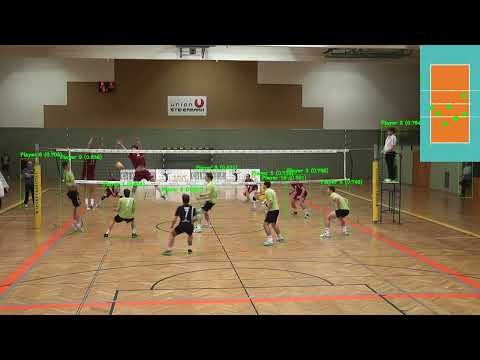

In [526]:
YouTubeVideo('VUICociP6os', width=640, height=360)

#### Выявленные проблемы

К предыдущим трем проблемам: 

1. Лишние детекции – среди игроков появляются судьи и зрители
2. Соперники – игроки на другой половине площадки определяются плохо в связи с тем, что их видно хуже
3. Исчезновение – игроки зачастую перекрывают друг друга – в особенности в моменты, когда собираются в центре поля после забитого мяча

добавились новые:

4. Разбег – зачастую игроки разбегаются за пределами игровой площадки, в связи с чем тоже возникает проблема отсева.
5. Прыжок – при прыжке проекция игрока уходит за пределы поля в связи с тем, что нижняя часть рамки поднимается за игроком вверх.
6. Рамки – порой рамка игрока оказывается больше, чем следовало бы, в связи с чем противник оказывается не на своей половине площадки.
7. Подрагивание – возникают заметные высокочастотные подрагивания точек на поле, связанные с тем, что рамки детекции смещаются.

## 4. Трекинг игроков <a id="tracking"></a>

Для решения большинства из указанных ранее проблем необходимо прибегнуть к трекингу игроков, чтобы на его основе отсеивать игроков на площадке и следить за их перемещениями.

В задаче трекинга воспользуемся алгоритмом DeepSORT, в основе которого лежит SORT, опирающийся на фильтры Калмана и расстояние Махалонобиса (за основу взята [реализация DeepSORT для PyTorch](https://github.com/ZQPei/deep_sort_pytorch)). Главное, в отличие от базового алгоритма, DeepSORT учитывает внешний вид человека, вследствие чего он не теряется, если на некоторое время другой человек закроет его в кадре, что достаточно часто происходит в рамках данной задачи.

In [12]:
from deepsort.deep_sort.deep_sort import DeepSort

random.seed(1)
colors = [(random.randint(0, 255), 
           random.randint(0, 255),
           random.randint(0, 255)) for i in range(15)]

def make_video_tracking_with_field(video_name, frames, 
                                   min_detect_conf=0.5, 
                                   bbox_color=(0, 255, 0),
                                   show_conf=True,
                                   field: Field = None,
                                   out_name='out'):
    
    yolo_model = YOLO("yolov8n.pt")
    yolo_model.to("cuda")
    ds_model = DeepSort("deepsort/deep_sort/model/ckpt.t7")

    # Open video and set frame to first from given range
    video_cap = cv2.VideoCapture(video_name)
    video_cap.set(cv2.CAP_PROP_POS_FRAMES, frames[0] - 1)
    ret, frame = video_cap.read()
    
    # Get information about FPS, width and heigth of the video and create new video with same parameters.
    fps = video_cap.get(cv2.CAP_PROP_FPS)
    w = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(f"{out_name}.mp4", fourcc, fps, (w, h))
    
    # For every frame in given range get detected boxes and for every bounding box make rectangle with label
    for frame_num in tqdm(range(frames[0], frames[-1] + 1)):

        for res in yolo_model(frame, conf=min_detect_conf, verbose=False):
            names = res.boxes.cls.int().tolist()
            confidences = res.boxes.conf.tolist()
            boxes = res.boxes.data.int().tolist()
            ds_boxes = []
            ds_confs = []
            for idx, (name, confidence, box) in enumerate(zip(names, confidences, boxes)):
                if labels.get(name):
                    ds_boxes.append([box[0], box[1], box[2] - box[0], box[3] - box[1]])
                    ds_confs.append(confidence)
            if ds_boxes:
                ds_model.update(np.asarray(ds_boxes), ds_confs, frame)

        tracks = [{'box': ds_model._tlwh_to_xyxy(cxcywh_to_tlwh(track.to_tlwh())),
                   'id': track.track_id} for track in  ds_model.tracker.tracks]

        for track in tracks:
            bbox = track['box']
            track_id = track['id']
            color = colors[track_id % len(colors)]
            label = f"Player {track_id}"
            cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 1)
            cv2.putText(frame, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_COMPLEX, 0.6, color, 2)

        if field is not None:
            field.draw_boxes_points_on_frame(frame, [track['box'] for track in tracks])
            
        out.write(frame)
        ret, frame = video_cap.read()
        if not ret:
            break

    video_cap.release()
    out.release()

In [123]:
make_video_tracking_with_field(vid_name, range(5625, 7625), field=field, out_name="yolo_track_field")

  0%|          | 0/2000 [00:00<?, ?it/s]

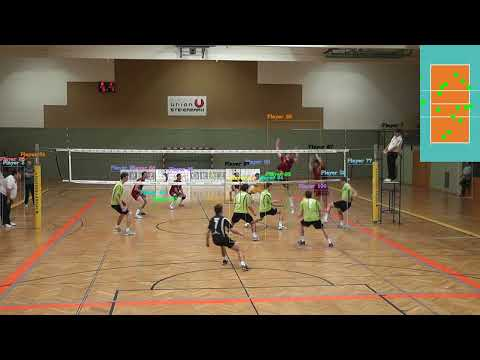

In [527]:
YouTubeVideo('ysDvTyY1hFI', width=640, height=360)

С помощью трекинга удалось практически полностью решить проблему 3 – исчезновение. Теперь перекрытые игроки не пропадают с площадки.

Однако, возникают сложности с большим количеством фантомных игроков, которые появляются вследствие неидеальности трекинга DeepSort.

Таким образом, общий набор проблем:

1. Лишние детекции – среди игроков появляются судьи и зрители
2. Соперники – игроки на другой половине площадки определяются плохо в связи с тем, что их видно хуже
3. ~~Исчезновение – игроки зачастую перекрывают друг друга – в особенности в моменты, когда собираются в центре поля после забитого мяча~~
4. Разбег – зачастую игроки разбегаются за пределами игровой площадки, в связи с чем тоже возникает проблема отсева.
5. Прыжок – при прыжке проекция игрока уходит за пределы поля в связи с тем, что нижняя часть рамки поднимается за игроком вверх.
6. Рамки – порой рамка игрока оказывается больше, чем следовало бы, в связи с чем противник оказывается не на своей половине площадки.
7. Подрагивание – возникают заметные высокочастотные подрагивания точек на поле, связанные с тем, что рамки детекции смещаются от кадра к кадру.
8. Фантомы – несуществующие игроки, которые появляются на площадке вследствие ошибок трекинга.
9. Перехват – трек может от одного игрока перейти к другому, а как частный случай – два трека вследствие быстрых действий прикрепляются к одному и тому же человеку.

Проблема 8 возникает по большей части вследствие проблем 1, 2 и 6. Решение проблемы 4 неразрывно связано с проблемой 1.

## 5. Отладка <a id="debugging"></a>

Самое главное – становится понятно, что исключительно "realtime"-трекинг невозможен – для принятия решения об отсеве детекций и трекинга нужно смотреть в прошлое и принимать решения на его основе. Для улучшения проекций игроков на площадке также необходимо уже после первичной обработки произвести сглаживание движений координат, чтобы они были плавными. Таким образом, нужно произвести предварительную обработку всех кадров, а затем уже производить видео на её основе, решая описанные ранее проблемы.

Для решения этой задачи упакуем всю функциональность в класс с набором функций, на основе которых будем производить поэтапную обработку:

1. Предобработка. Обработать видео, отбрасывая детекции игроков за пределами интересующей половины площадки, попутно собрав треки игроков на площадке.
2. Постобработка. Удалить лишние треки, а затем сгладить перемещения проекций игроков.
3. Сгенерировать видео с результатами.

### Предобработка

Задача предобработки состоит в том, чтобы при первом проходе по кадрам видеозаписи отбросить то, что наверняка впоследствии не понадобится: в частности, треки игроков на другой половине площадки, судей и зрителей.

Для решения этой задачи прямо во время первичной обработки видео с нахождением детекций и трекинга игроков раз в несколько секунд производится проверка новых треков на предмет того, что они имеют достаточную длительность, чтобы их можно было считать неслучайными, а также принадлежат игрокам, находящимся на ближайшей половине площадки. Чтобы не отбрасывать треки игроков, которые осуществляют прыжок у сетки, вследствие чего их проекция заметно смещается, отсев производится на основе длительности их нахождения на чужой половине площадки. Логика здесь проста – игрок не может повиснуть в воздухе более, чем на несколько секунд, вследствие чего, если нахождение на чужой половине систематическое, игрок нас не интересует.

Чтобы избежать прикрепления двух треков к одному игроку, результаты трекинга проверяются на предмет IOU (Intersection over union). Если отношение площади пересечения рамок к площади объединения выше, чем заданное, более новый трек для этого кадра отбрасывается, чтобы не дублировать работу в дальнейшем.

В итоге, к концу предобработки мы имеем датасет, где строки – кадры, столбцы – id треков. 
Таким образом, предобработка позволила решить проблемы 1, 4, 5 – лишние детекции, разбег и прыжок. Проблема 2 была устранена тем, что противники в принципе не рассматриваются в связи со сложностью их определения даже на глаз. Проблема 9 устранена лишь частична – закрыт частный случай с двумя треками на одном человеке.


### Постобработка

Задача постобработки – проанализировать результат предобработки на предмет более сложных ложных детекций и треков, т.е. отшлифовать результат, взглянув уже на полную историю трека.

Предобработка не позволила решить более сложные проблемы, связанные, например, с переходом трека от одного игрока к другому. В целом, если подобное будет происходить внутри команды, это не будет большой проблемой, однако если трек от игрока на одной половине площадки передается игроку на другой половине, то проблема становится значительнее.

Для решения этой проблемы впоследствии рассматривается каждый трек на предмет длительного нахождения игрока за пределами своей игровой площадки. То есть, мы отсеяли треки, которые наверняка принадлежат противникам, однако появляются такие, где соотношение времени присутствия на нужной части площадки к времени присутствия на противоположной составляет примерно 0.5 – то есть, совершенно не ясно, свой он или чужой. Или же внезапно среди постоянного присутствия игрок достаточно резко оказывается за пределами площадки на длительное время. Для того, чтобы решить эту проблему, каждый трек проверяется на предмет присутствия в нем длительного периода отсутствия игрока на площадке, а затем каждый такой период отбрасывается из рассмотрения.

Таким образом удалось почти полностью решить проблему 9.

Ниже приведен код, который производит пред- и постобработку, а затем генерируется видеозапись с окончательным результатом.

In [512]:
from deepsort.deep_sort.sort.track import TrackState
import torchvision.ops.boxes as bops

class VolleyTracking:


    def __init__(self, yolo_weights, ds_weights, field: Field):
        self.yolo = YOLO(yolo_weights)
        self.ds = DeepSort(ds_weights)
        self.field = field


    def delete_track(self, track):
        track.state = TrackState.Deleted

    
    def is_track_significant(self, track, min_ratio):
        track_record = track.loc[track.first_valid_index():track.last_valid_index()]
        return track_record.count() / len(track_record) >= min_ratio


    def is_field_player(self, track, min_ratio):
        on_field = [field.is_box_on_field(box) for box in track if not np.isnan(box).any()]
        return on_field.count(True) / len(on_field) >= min_ratio 

    
    def is_overlapping(self, track_1, track_2, min_value=0.7):
        return bool(bops.box_iou(torch.tensor([track_1]), torch.tensor([track_2])) >= min_value)


    def remove_overlapping(self, current_frame, min_value=0.7):
        track_ids = list(current_frame.keys())
        remove_ids = set()
        for i in range(len(track_ids)):
            for j in range(i + 1, len(track_ids)):
                i_key, j_key = track_ids[i], track_ids[j]
                if i_key == 6 and j_key == 15:
                    r = bops.box_iou(torch.tensor([current_frame[i_key]]), torch.tensor([current_frame[j_key]]))
                if self.is_overlapping(current_frame[i_key], current_frame[j_key], min_value=min_value):
                    remove_ids.add(max(i_key, j_key))
        for idx_key in remove_ids:
            current_frame[idx_key] = np.nan
        return current_frame


    def tracking_processing(self, frame, conf, verbose=False):
        for res in self.yolo(frame, conf=conf, verbose=verbose):
            names = res.boxes.cls.int().tolist()
            confidences = res.boxes.conf.tolist()
            boxes = res.boxes.data.int().tolist()
            ds_boxes = []
            ds_confs = []
            for (name, confidence, box) in zip(names, confidences, boxes):
                if labels.get(name):
                    ds_boxes.append([box[0], box[1], box[2] - box[0], box[3] - box[1]])
                    ds_confs.append(confidence)
            if ds_boxes:
                    self.ds.update(np.asarray(ds_boxes), ds_confs, frame)

    # Filter new tracks: remove if NA's count > min_not_na or if player is not on field for too long
    def tracking_filtering(self, tracks, tracking_df, new_tracking_cols, min_exists_ratio, min_on_field_ratio):
        for track_id in new_tracking_cols:
            cur_track = tracking_df[track_id]
            should_save = False

            # If too much NA's or player is not a field player
            if not (self.is_track_significant(cur_track, min_exists_ratio) 
                    and self.is_field_player(cur_track, min_on_field_ratio)):
                del_idx = next((i for i in range(len(tracks)) if tracks[i].track_id == track_id), None)
                if del_idx is not None:
                    self.delete_track(tracks[del_idx])
                tracking_df = tracking_df.drop(track_id, axis=1)
        return tracking_df


    # Preprocess video to find tracks and points
    def preprocessing(self, video_cap: cv2.VideoCapture, frames, min_conf=0.5,
                      check_on_field_dur=5, min_exists_ratio=0.4, min_on_field_ratio=0.4):
        tracking_df = pd.DataFrame()
        video_cap.set(cv2.CAP_PROP_POS_FRAMES, frames[0] - 1)
        ret, frame = video_cap.read()
        fps = video_cap.get(cv2.CAP_PROP_FPS)
        tracking_exists_cnt = int(fps * check_on_field_dur * min_exists_ratio)
        tracking_check_cnt = fps * check_on_field_dur
        new_tracking_cols = set()
        for i, frame_num in enumerate(tqdm(range(frames[0], frames[-1] + 1)), start=1):
            
            self.tracking_processing(frame, conf=min_conf)

            current_frame = {}
            for track in self.ds.tracker.tracks:
                bbox = self.ds._tlwh_to_xyxy(cxcywh_to_tlwh(track.to_tlwh()))
                track_id = track.track_id
                current_frame[track_id] = bbox
                
                if track_id not in tracking_df.columns:
                    new_tracking_cols.add(track_id)

            current_frame = self.remove_overlapping(current_frame)
            
            tracking_df = pd.concat([tracking_df, pd.DataFrame.from_dict({frame_num: current_frame}, orient='index')])

            if i % tracking_check_cnt == 0 or i == frames[-1]:
                tracking_df = self.tracking_filtering(self.ds.tracker.tracks, tracking_df, new_tracking_cols,
                                                      min_exists_ratio=min_exists_ratio,
                                                      min_on_field_ratio=min_on_field_ratio)
                new_tracking_cols = set()

            ret, frame = video_cap.read()
            if not ret:
                break
        
        return tracking_df

    # Find (start, end) pairs, when tracked player was out from field for too long
    def find_not_on_field(self, track, max_not_on_field):
        res_1 = track.dropna().apply(lambda x: field.is_box_on_field(x))
        res_2 = pd.concat([res_1.iloc[0:1], res_1[res_1.diff() == True], res_1.iloc[-1:].apply(lambda x: not x)])
        res_3 = res_2[(res_2 == True) & (res_2.index.to_series().diff() > max_not_on_field)]
        res_4 = res_3.index.to_series().apply(lambda x: res_2.index[res_2.index.get_loc(x) - 1])
        return [(v, i) for i, v in res_4.items()]


    def postprocessing(self, tracking_df, max_not_on_field=50):
        for track_id in tracking_df:
            for start_idx, end_idx in self.find_not_on_field(tracking_df[track_id], max_not_on_field):
                tracking_df[track_id].loc[start_idx:end_idx] = np.nan
        return tracking_df


    def render_video(self, video_name, tracking_df, out_name):
        frames = tracking_df.index
        video_cap = cv2.VideoCapture(video_name)
        video_cap.set(cv2.CAP_PROP_POS_FRAMES, frames[0] - 1)
        ret, frame = video_cap.read()
        fps = video_cap.get(cv2.CAP_PROP_FPS)
        w = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(f"{out_name}.mp4", fourcc, fps, (w, h))
        for frame_num, row in tqdm(tracking_df.iterrows(), total=tracking_df.shape[0]):
            boxes = []
            for track_id, box in row.dropna().items():
                boxes.append(box)
                label = f"Track {track_id}"
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), color, 1)
                cv2.putText(frame, label, (box[0], box[1]-10), cv2.FONT_HERSHEY_COMPLEX, 0.6, color, 2)

            if field is not None:
                field.draw_boxes_points_on_frame(frame, boxes)
            
            out.write(frame)
            ret, frame = video_cap.read()
            if not ret:
                break
        video_cap.release()
        out.release()
               
            

In [495]:
vid_field_coord = [[0, 1041],[1920, 990],[1172, 609],[396,614]]
img_field_coord = [[180, 1630],[820, 1630],[820, 330],[180, 330]]

video = cv2.VideoCapture(get_video_name_by_number(1))
field_image = cv2.imread('field.png')
frame = video.read()[1]

field = Field(vid_field_coord, img_field_coord, frame, field_image)

In [516]:
vtracking = VolleyTracking("yolov8n.pt", "deepsort/deep_sort/model/ckpt.t7", field)
video = cv2.VideoCapture(get_video_name_by_number(1))

res = vtracking.preprocessing(video, range(5625, 7625))
res = vtracking.postprocessing(res)
vtracking.render_video(vid_name, res, "filtered_tracking")

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

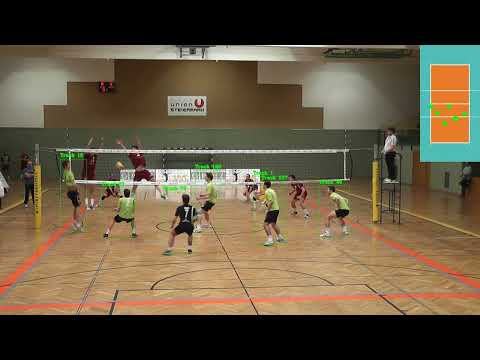

In [528]:
YouTubeVideo('dmlEw_pnAT0', width=640, height=360)

По итогам работы набор проблем следующий:

1. ~~Лишние детекции – среди игроков появляются судьи и зрители.~~
2. ~~Соперники – игроки на другой половине площадки определяются плохо в связи с тем, что их видно хуже.~~
3. ~~Исчезновение – игроки зачастую перекрывают друг друга – в особенности в моменты, когда собираются в центре поля после забитого мяча.~~
4. ~~Разбег – зачастую игроки разбегаются за пределами игровой площадки, в связи с чем тоже возникает проблема отсева.~~
5. ~~Прыжок – при прыжке проекция игрока уходит за пределы поля в связи с тем, что нижняя часть рамки поднимается за игроком вверх.~~
6. Рамки – порой рамка игрока оказывается больше, чем следовало бы, в связи с чем противник оказывается не на своей половине площадки.
7. Подрагивание – возникают заметные высокочастотные подрагивания точек на поле, связанные с тем, что рамки детекции смещаются от кадра к кадру.
8. Фантомы – несуществующие игроки, которые появляются на площадке вследствие ошибок трекинга.
9. Перехват – трек может от одного игрока перейти к другому, а как частный случай – два трека вследствие быстрых действий прикрепляются к одному и тому же человеку.

При этом проблемы 6 и 9 решены практически полностью.

### TODO

С учетом того, что многие проблемы решены частично и однозначно будут проявляться, объем работы предстоит все еще достаточно большой.

Чтобы решать проблемы 6, 7, 8 и 9 окончательно, а также в принципе подводить статистику, необходимо определять номера игроков на площадке, чтобы в итоге иметь треки перемещения конкретных игроков. Задача выглядит весьма творческой, потому что зачастую будут возникать ситуации, когда 4-5 из 6 игроков удастся определить, а других придется находить методом исключения или же иными способами. Трекинг игроков также наверняка будет неполным, с пропусками, в связи с чем нужно будет рассматривать различные варианты их заполнения. Проблема с подрагиванием решается достаточно легко – здесь можно применить скользящее среднее или иной фильтр для временных рядов. Прыжок и потеря проекции игрока тоже решаемы – перемещение игрока также можно рассмотреть как временной ряд, в котором необходимо срезать пики, потому что прыжок и возврат человека на площадку будет выглядеть именно как резкий пик на практически гладком графике.

Все эти размышления остается лишь реализовывать, упаковывая в итоге в понятные и задокументированные файлы и классы.